In [16]:
# Importing important packages
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

## import Signal and label Data

In [17]:
# load signal data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
signal_files = ["/X_TRAIN.pkl","/X_TEST.pkl","/X_VAL.pkl",]

x_train = list()
x_test = list()
x_val = list()

for i in signal_files:
    if i == "/X_TRAIN.pkl":
        with open(Path + "/X_TRAIN.pkl", "rb") as f:
            x_train = pickle.load(f)
    elif i == "/X_TEST.pkl":
        with open(Path + "/X_TEST.pkl", "rb") as f:
            x_test = pickle.load(f)
    elif i == "/X_VAL.pkl":
        with open(Path + "/X_VAL.pkl", "rb") as f:
            x_val = pickle.load(f)

# convert to from np arrays to tensors
x_train = tf.convert_to_tensor(x_train, dtype = tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype = tf.float32)


In [18]:
# process signal data
def apply_stft(numeric_tensors):
    
    frame_length = 64
    frame_step = 16
    fft_length = 64
    numeric_tensors = tf.transpose(numeric_tensors, [0, 2, 1])
    stft_results = tf.signal.stft(
        numeric_tensors,
        frame_length = frame_length,
        frame_step = frame_step,
        fft_length = fft_length
    )
    
    spectogram = tf.abs(stft_results)

    return spectogram

# apply stft
x_train = apply_stft(x_train)
x_test = apply_stft(x_test)
x_val = apply_stft(x_val)

In [19]:
# Verify shapes
print(f"The shapes are:\n- x_train is {x_train.shape} \n- x_test is {x_test.shape} \n- x_val is {x_val.shape}")

The shapes are:
- x_train is (12123, 12, 59, 33) 
- x_test is (1512, 12, 59, 33) 
- x_val is (1479, 12, 59, 33)


In [20]:
# load label data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
label_files = ["/Y_TRAIN.pkl","/Y_TEST.pkl","/Y_VAL.pkl",]

for i in label_files:
    if i == "/Y_TRAIN.pkl":
        with open(Path + "/Y_TRAIN.pkl", "rb") as f:
            y_train = pickle.load(f)
    elif i == "/Y_TEST.pkl":
        with open(Path + "/Y_TEST.pkl", "rb") as f:
            y_test = pickle.load(f)
    elif i == "/Y_VAL.pkl":
        with open(Path + "/Y_VAL.pkl", "rb") as f:
            y_val = pickle.load(f)

# process labels
def multihot_encode(pd_series_labels):
    # pandas series to list
    list_labels = pd_series_labels.to_list()

    # convert to ragged vector
    ragged_list_labels = tf.ragged.constant(list_labels)

    # setup string lookup and adapt
    str_lookup_layer = layers.StringLookup(output_mode = "multi_hot")
    str_lookup_layer.adapt(ragged_list_labels) 
    multi_hot_labels = str_lookup_layer(ragged_list_labels)

    return multi_hot_labels

# appyl multi hot encoding
y_train = tf.cast(multihot_encode(y_train),dtype = tf.float32)
y_test = tf.cast(multihot_encode(y_test),dtype = tf.float32)
y_val = tf.cast(multihot_encode(y_val),dtype = tf.float32)

In [21]:
# Verify shapes
print(f"The shapes are:\n- y_train is {y_train.shape} \n- y_test is {y_test.shape} \n- y_val is {y_val.shape}")

The shapes are:
- y_train is (12123, 7) 
- y_test is (1512, 7) 
- y_val is (1479, 7)


## Model Creation

In [22]:
# Conv2D Model

# Input layers
InputLayer = layers.Input(shape=(12, 59, 33))

# 2D-CNN Block 1
x = layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (1,1), activation = "relu", padding = "same")(InputLayer)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# 2D-CNN Block 2
x = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# Classification Overhead
x = layers.Dense(units = 128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(units = 64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
OutputLayer = layers.Dense(units = 7, activation = "sigmoid")(x)

# Model Creation
model = tf.keras.Model(inputs = InputLayer, outputs = OutputLayer, name = "2DCNN_STFT_Model")

In [23]:
# Define custom metrics

# subclass custom Hamming Loss metric (Not using tensorflow addons here; version clash)
@tf.keras.utils.register_keras_serializable()
class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

# subclass custom Hamming score metric
@tf.keras.utils.register_keras_serializable()
class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [24]:
# model compilation (loss function and optimiser)
roc_auc = tf.keras.metrics.AUC(curve = "ROC", name = "ROC-AUC")
accuracy = tf.keras.metrics.BinaryAccuracy(name = "Accuracy")
recall = tf.keras.metrics.Recall(name = "Recall", thresholds = 0.35)
precision = tf.keras.metrics.Precision(name = "Precision", thresholds = 0.4)
F2_score = tf.keras.metrics.FBetaScore(name = "F2", beta = 2.0, average = "weighted", threshold = 0.35)

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [accuracy,
                         roc_auc,
                         F2_score,
                         precision,
                         recall,
                         HammingLoss(), HammingScore()])

In [25]:
# get summary
model.summary()

Model: "2DCNN_STFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 59, 33)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 59, 64)     │        52,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 29, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 29, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 29, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 29, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3, 14, 128)     │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3, 14, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │        18,823 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,015 (402.40 KB)

 Trainable params: 102,823 (401.65 KB)

 Non-trainable params: 192 (768.00 B)

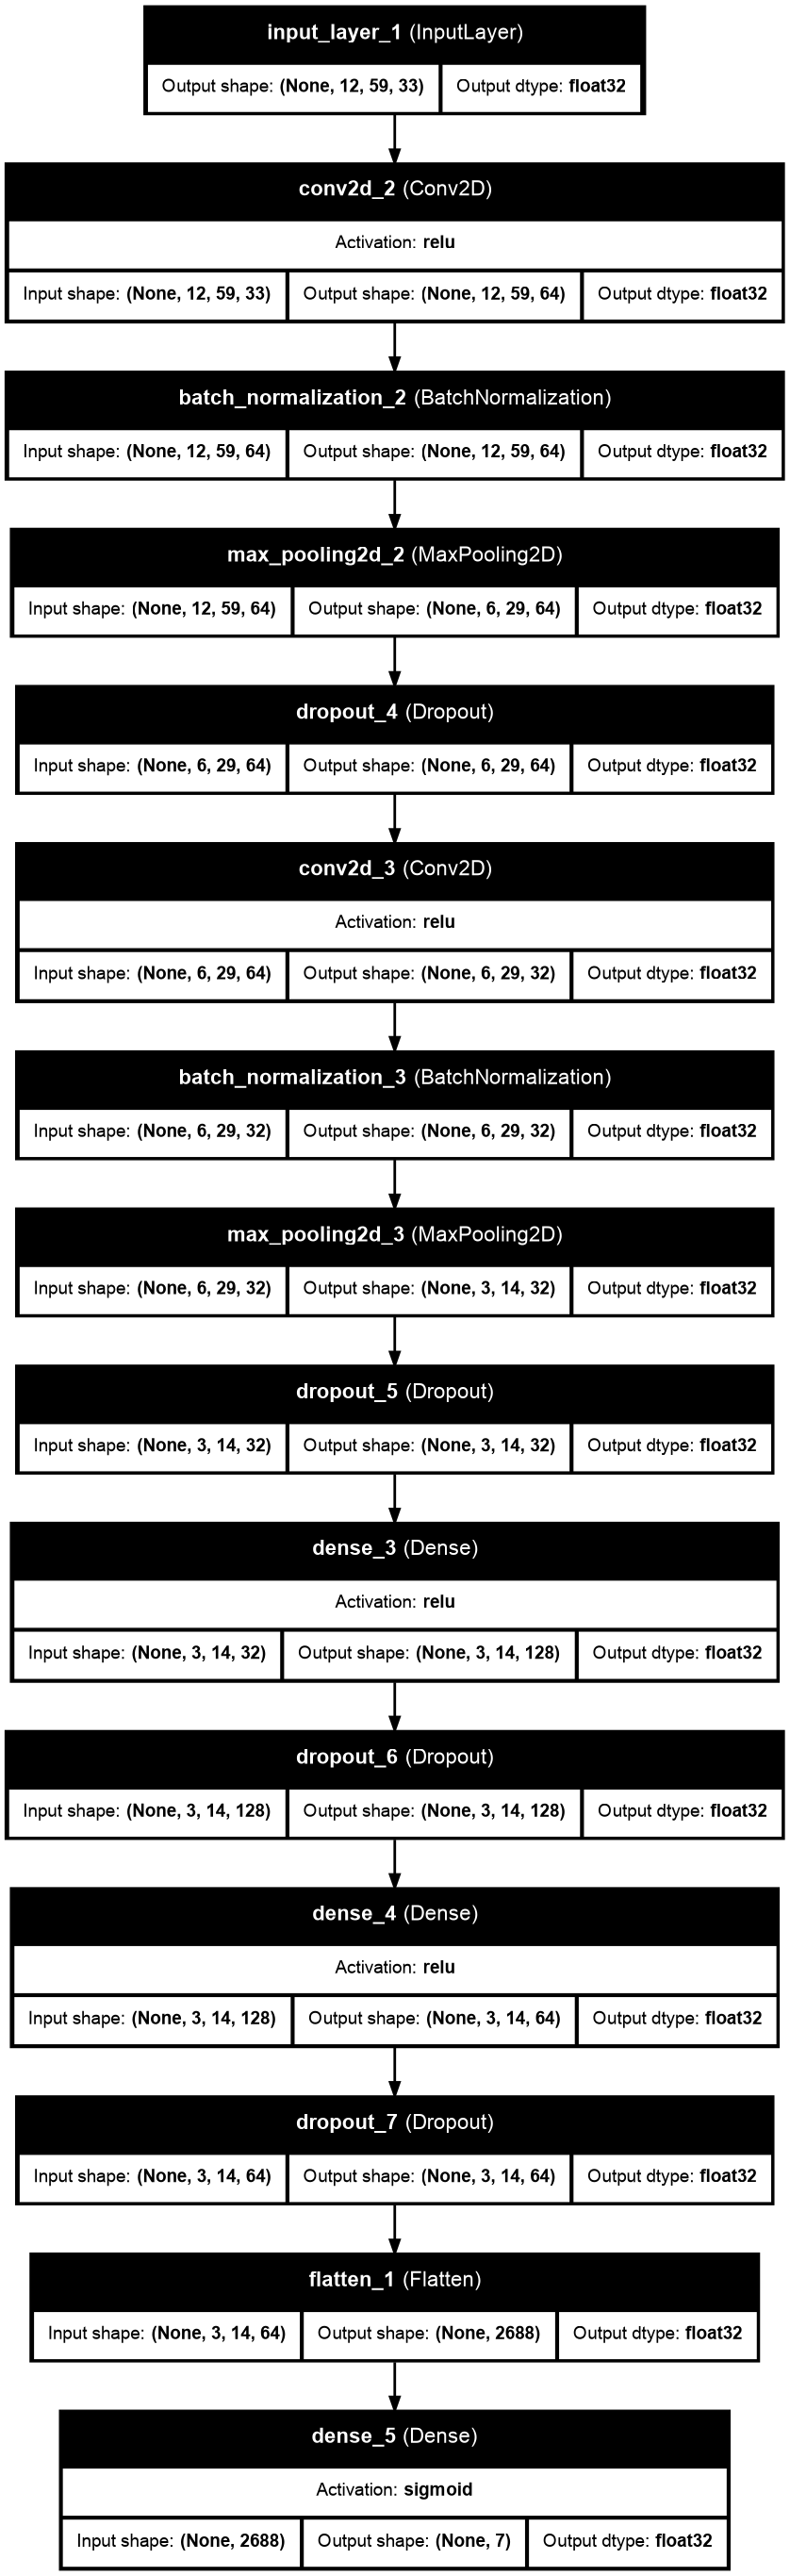

In [26]:
# visualise model
tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final_STFT.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## Trial Runs

In [27]:
# set callbacks
Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_Precision", patience = 12, restore_best_weights = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5)
]

In [28]:
# train  model
History = model.fit(
    x = x_train,
    y = y_train,
    validation_data =(x_val, y_val),
    epochs = 100,
    batch_size = 32,
    callbacks = Callbacks
)

Epoch 1/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - Accuracy: 0.8020 - F2: 0.5818 - Hamming_loss: 0.1980 - Hamming_score: 0.8020 - Precision: 0.3274 - ROC-AUC: 0.7333 - Recall: 0.7758 - loss: 0.1180 - val_Accuracy: 0.8106 - val_F2: 0.6480 - val_Hamming_loss: 0.1894 - val_Hamming_score: 0.8106 - val_Precision: 0.1861 - val_ROC-AUC: 0.7139 - val_Recall: 1.0000 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - Accuracy: 0.8134 - F2: 0.6111 - Hamming_loss: 0.1866 - Hamming_score: 0.8134 - Precision: 0.3421 - ROC-AUC: 0.7618 - Recall: 0.8575 - loss: 0.1044 - val_Accuracy: 0.8144 - val_F2: 0.6480 - val_Hamming_loss: 0.1856 - val_Hamming_score: 0.8144 - val_Precision: 0.1982 - val_ROC-AUC: 0.7230 - val_Recall: 1.0000 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - Accuracy: 0.8143 - F2: 0.6149 - Hamming_loss: 0.1857 - Hamming_score: 0.8143 - Precision: 0.3458 - ROC-AUC: 0.7635 - Recall: 0.8

In [29]:
# evaluate model
Evaluation_result = model.evaluate(
    x = x_test,
    y = y_test,
    batch_size = 32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.8159 - F2: 0.6212 - Hamming_loss: 0.1841 - Hamming_score: 0.8159 - Precision: 0.3856 - ROC-AUC: 0.7587 - Recall: 0.9038 - loss: 0.1028


In [30]:
# sample prediction
results = model.predict(x = x_test[99:100])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[2.3012090e-04 5.0804543e-01 3.5209048e-01 3.5212383e-01 3.6794510e-01
  2.5006378e-01 1.9959368e-01]]
